In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import scipy.io as sio
from xmitgcm import open_mdsdataset
import pandas as pd
import xarray as xr
from scipy import interpolate
from skimage import measure
from copy import deepcopy
import time

/home/tls2913/.conda/envs/geo_scipy/lib/python3.6/site-packages/xmitgcm/utils.py:336: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)


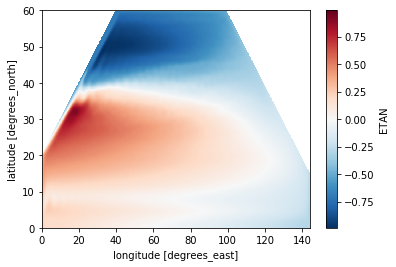

In [3]:
data_dir = '/swot/SUM01/tongya/cox/fine/run_quik_ex2/'

ds = open_mdsdataset(data_dir,prefix='etan_ave').chunk()

lon = ds.XC
lat = ds.YC

ssh = ds['ETAN'][70:100, :, :]
ssh = ssh.mean('time')
ssh = ssh.where(ssh != 0)

ssh.plot()

In [4]:
lc = 0
rc = 144
nc = 40
sc = 5
dir_ssh = '/swot/SUM01/tongya/RCLV/flt_2d/001/'
ds = open_mdsdataset(dir_ssh, prefix='Eta').chunk()
sla = ds.Eta - ssh
sla = sla.sel(XC=slice(lc, rc), YC=slice(sc, nc)) * 100
sla

/home/tls2913/.conda/envs/geo_scipy/lib/python3.6/site-packages/xmitgcm/utils.py:336: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)


<xarray.DataArray (time: 91, YC: 350, XC: 1440)>
dask.array<shape=(91, 350, 1440), dtype=float32, chunksize=(1, 350, 1440)>
Coordinates:
  * XC       (XC) >f4 0.05 0.15 0.25 0.35 0.45 ... 143.65 143.75 143.85 143.95
  * YC       (YC) >f4 5.05 5.15 5.25 5.35 5.45 ... 39.55 39.65 39.75 39.85 39.95
    rA       (YC, XC) >f4 dask.array<shape=(350, 1440), chunksize=(350, 1440)>
    Depth    (YC, XC) >f4 dask.array<shape=(350, 1440), chunksize=(350, 1440)>
    iter     (time) int64 dask.array<shape=(91,), chunksize=(1,)>
  * time     (time) int64 0 96 192 288 384 480 ... 8160 8256 8352 8448 8544 8640

In [5]:
def find_nearest_id(x0, x1):
    index = np.abs(x0 - x1).argmin()
    return index

## Fixed circle

In [150]:
lc = 0
rc = 144
nc = 40
sc = 5

m1 = 0  # the num of overlap case
tnum = 0  # total num

flux1 = np.zeros((1, 30))
flux2 = np.zeros((1, 30))

df = pd.read_pickle(
    '/home/tls2913/scripts/RCLV/statistics_2d/rclv_30_0.1/df_rand.pkl')
cols = ['cx', 'cy', 'L', 'mon', 'flux1', 'flux2']
df_flux = pd.DataFrame(columns=cols)

for mon in np.arange(1):

    data_dir1 = '/swot/SUM01/tongya/RCLV/output/flt_2d/' + \
        str(mon+1).zfill(3) + '/float_trajectories_netcdf/'
    ds1 = xr.open_mfdataset(data_dir1 + '*.nc')

    x0 = ds1.sel(x0=slice(lc, rc), y0=slice(sc, nc)).x0.load().data
    y0 = ds1.sel(x0=slice(lc, rc), y0=slice(sc, nc)).y0.load().data

    xdata = ds1.sel(time=np.arange(0, 86400*30, 86400),
                    x0=slice(lc, rc), y0=slice(sc, nc)).x.load().data
    ydata = ds1.sel(time=np.arange(0, 86400*30, 86400),
                    x0=slice(lc, rc), y0=slice(sc, nc)).y.load().data


    #dftmp = df.loc[(df.mon == mon+1) & (df.L==90.0) ]
    dftmp = df.iloc[1152]

    for kk in np.arange(1):
    #for kk in np.arange(dftmp.shape[0]):

        posx = dftmp['cx']
        posy = dftmp['cy']
        print(str(kk) + ' ' + str(posx) + ' ' + str(posy))
        xx0 = max(0, int(posx)-8)
        xx1 = min(144, int(posx)+8)
        yy0 = max(5, int(posy)-6)
        yy1 = min(40, int(posy)+6)

        px = xdata[:, ((yy0-5)*80):((yy1-5)*80), (xx0*80):(xx1*80)]
        py = ydata[:, ((yy0-5)*80):((yy1-5)*80), (xx0*80):(xx1*80)]

        mask_eddy = np.zeros((30, (yy1-yy0)*10, (xx1-xx0)*10))
        mask_eddy_new = np.zeros((30, (yy1-yy0)*80, (xx1-xx0)*80))

        num1 = np.zeros((30))
        num2 = np.zeros((30))
        num1_tmp = np.zeros((30))  # for saving flux1 tmp
        num2_tmp = np.zeros((30))

        lon0 = np.arange(0.05, 144, 0.1)
        lat0 = np.arange(10.05, 35, 0.1)
        pxin_ds1 = [1, 1, 1]
        pyin_ds1 = [1, 1, 1]
        pxout_ds1 = [1, 1, 1]
        pyout_ds1 = [1, 1, 1]
        boun_x1 = [1, 1, 1]
        boun_y1 = [1, 1, 1]
        picnum = 0

        for day in np.arange(30):
            eddyidx = dftmp.lnid - xx0 * 10
            eddyidy = dftmp.ltid - yy0 * 10 + 100

            # if day == 29:
            #    eddyidx = eddyidx + deltax
            #    eddyidy = eddyidy + deltay

            if eddyidx.max() >= mask_eddy.shape[2] or eddyidy.max() >= mask_eddy.shape[1]:
                print('error in ' + str(kk))
                print('error in ' + str(mon+1))
                break

            mask_eddy[day, eddyidy, eddyidx] = 1

            ssh_x = np.arange(xx0+0.05, xx1, 0.1)
            ssh_y = np.arange(yy0+0.05, yy1, 0.1)
            x_new = np.arange(xx0+0.00625, xx1, 0.0125)
            y_new = np.arange(yy0+0.00625, yy1, 0.0125)

            fun = interpolate.interp2d(ssh_x, ssh_y, mask_eddy[day, :, :])
            mask_tmp = fun(x_new, y_new)
            mask_tmp[np.where(mask_tmp > 0)] = 1

            mask_eddy_new[day, :, :] = mask_tmp

            mask1 = deepcopy(mask_eddy_new[0, :, :])
            mask2 = deepcopy(mask_eddy_new[0, :, :]) - 1
            mask2[np.where(mask2 < 0)] = 1

            contours = measure.find_contours(mask_eddy_new[day, :, :], 0)

            pxin = px[day, :, :] * mask1
            pyin = py[day, :, :] * mask1
            pxin = np.reshape(pxin, (mask1.shape[0] * mask1.shape[1]))
            pyin = np.reshape(pyin, (mask1.shape[0] * mask1.shape[1]))

            pxout = px[day, :, :] * mask2
            pyout = py[day, :, :] * mask2
            pxout = np.reshape(pxout, (mask2.shape[0] * mask2.shape[1]))
            pyout = np.reshape(pyout, (mask2.shape[0] * mask2.shape[1]))

            for n, contour in enumerate(contours):
                boun_x = x_new[contour[:, 1].astype(int)]
                boun_y = y_new[contour[:, 0].astype(int)]

            if day in [0, 14, 29]:

                pxin_ds1[picnum] = pxin
                pyin_ds1[picnum] = pyin
                pxout_ds1[picnum] = pxout
                pyout_ds1[picnum] = pyout
                boun_x1[picnum] = boun_x
                boun_y1[picnum] = boun_y
                picnum = picnum + 1

            num1[day] = np.sum(measure.points_in_poly(
                np.array([pxin, pyin]).T, np.array([boun_x, boun_y]).T))
            num2[day] = np.sum(measure.points_in_poly(
                np.array([pxout, pyout]).T, np.array([boun_x, boun_y]).T))

        num1_tmp = num1
        num2_tmp = num2

np.savez('/home/tls2913/scripts/RCLV/statistics_2d/rclv_30_0.1/Figs/data_fix_case1', pxin_ds1, pyin_ds1, pxout_ds1, pyout_ds1, boun_x1, boun_y1, num1, num2)

0 51.36694085180966 17.284714459235552


In [147]:
df.iloc[1152]

cx                                                51.3669
cy                                                17.2847
x       [52.26694085180966, 52.265128860634356, 52.259...
y       [17.284714459235552, 17.341795986926464, 17.39...
L                                                      90
mon                                                     1
lnid    [513, 514, 515, 510, 511, 512, 513, 514, 515, ...
ltid    [64, 64, 64, 65, 65, 65, 65, 65, 65, 65, 65, 6...
Name: 1152, dtype: object

In [149]:
num1

array([18752., 16995., 15403., 13888., 12430., 10989.,  9661.,  8514.,
        7506.,  6706.,  6010.,  5443.,  4949.,  4545.,  4296.,  4179.,
        4117.,  3933.,  3817.,  3572.,  3381.,  3168.,  3250.,  3050.,
        2969.,  2879.,  2731.,  2584.,  2359.,  1842.])

## Moving circle

In [92]:
lc = 0
rc = 144
nc = 40
sc = 5

m1 = 0  # the num of overlap case
tnum = 0  # total num

flux1 = np.zeros((1, 30))
flux2 = np.zeros((1, 30))

df = pd.read_pickle('/home/tls2913/scripts/RCLV/statistics_2d/rclv_30_0.1/df_rand.pkl')
cols = ['cx', 'cy', 'L', 'mon', 'flux1', 'flux2']
df_flux = pd.DataFrame(columns=cols)

for mon in np.arange(1):

    data_dir1 = '/swot/SUM01/tongya/RCLV/output/flt_2d/' + \
        str(mon+1).zfill(3) + '/float_trajectories_netcdf/'
    ds1 = xr.open_mfdataset(data_dir1 + '*.nc')

    x0 = ds1.sel(x0=slice(lc, rc), y0=slice(sc, nc)).x0.load().data
    y0 = ds1.sel(x0=slice(lc, rc), y0=slice(sc, nc)).y0.load().data

    xdata = ds1.sel(time=np.arange(0, 86400*30, 86400),
                    x0=slice(lc, rc), y0=slice(sc, nc)).x.load().data
    ydata = ds1.sel(time=np.arange(0, 86400*30, 86400),
                    x0=slice(lc, rc), y0=slice(sc, nc)).y.load().data

    uu = ds1.sel(time=np.arange(0, 86400*30, 86400),
                 x0=slice(lc, rc), y0=slice(sc, nc)).u.values
    vv = ds1.sel(time=np.arange(0, 86400*30, 86400),
                 x0=slice(lc, rc), y0=slice(sc, nc)).v.values

    #dftmp = df.loc[(df.mon == mon+1) & (df.L==90.0) ]
    dftmp = df.iloc[1136]
    
    for kk in np.arange(1):
    #for kk in np.arange(1):    
        posx = dftmp['cx']
        posy = dftmp['cy']
        print(str(kk) + ' ' + str(posx) + ' ' + str(posy))
        xx0 = max(0, int(posx)-8)
        xx1 = min(144, int(posx)+8)
        yy0 = max(5, int(posy)-6)
        yy1 = min(40, int(posy)+6)

        #utmp = uu.interp(x0=posx, y0=posy)
        #vtmp = vv.interp(x0=posx, y0=posy)
        utmp = np.zeros(30)
        vtmp = np.zeros(30)
        
        utmp = uu[:, find_nearest_id(y0, posy), find_nearest_id(x0, posx)]
        vtmp = vv[:, find_nearest_id(y0, posy), find_nearest_id(x0, posx)]
        #fun_u = interpolate.interp2d(x0, y0, uu[0, :, :])
        px = xdata[:, ((yy0-5)*80):((yy1-5)*80), (xx0*80):(xx1*80)]
        py = ydata[:, ((yy0-5)*80):((yy1-5)*80), (xx0*80):(xx1*80)]

        mask_eddy = np.zeros((30, (yy1-yy0)*10, (xx1-xx0)*10))
        mask_eddy_new = np.zeros((30, (yy1-yy0)*80, (xx1-xx0)*80))

        num1 = np.zeros(30)
        num2 = np.zeros(30)
        num1_tmp = np.zeros(30)  # for saving flux1 tmp
        num2_tmp = np.zeros(30)

        lon0 = np.arange(0.05, 144, 0.1)
        lat0 = np.arange(10.05, 35, 0.1)
        pxin_ds1 = [1, 1, 1]
        pyin_ds1 = [1, 1, 1]
        pxout_ds1 = [1, 1, 1]
        pyout_ds1 = [1, 1, 1]
        boun_x1 = [1, 1, 1]
        boun_y1 = [1, 1, 1]
        picnum = 0
        
        cenx = np.zeros(30)
        ceny = np.zeros(30)
        cenx[0] = posx
        ceny[0] = posy
        for day in np.arange(30):
            
            eddyidx = dftmp.lnid - xx0 * 10
            eddyidy = dftmp.ltid - yy0 * 10 + 100

            if np.isnan(utmp[day]):
                utmp[day] = vtmp[day] = 0

            if day > 0:

                deltax = int(np.mean(utmp[:day])*day*86400/100000*10)
                deltay = int(np.mean(vtmp[:day])*day*86400/100000*10)                
                eddyidx = eddyidx + deltax
                eddyidy = eddyidy + deltay
                cenx[day] = cenx[day-1] + utmp[day-1]*86400/100000
                ceny[day] = ceny[day-1] + vtmp[day-1]*86400/100000
            #plt.plot(eddyidx, eddyidy, '.')
            if eddyidx.max() >= mask_eddy.shape[2] or eddyidy.max() >= mask_eddy.shape[1]:
                print('error in ' + str(kk))
                print('error in ' + str(mon+1))
                break

            mask_eddy[day, eddyidy, eddyidx] = 1

            ssh_x = np.arange(xx0+0.05, xx1, 0.1)
            ssh_y = np.arange(yy0+0.05, yy1, 0.1)
            x_new = np.arange(xx0+0.00625, xx1, 0.0125)
            y_new = np.arange(yy0+0.00625, yy1, 0.0125)

            fun = interpolate.interp2d(ssh_x, ssh_y, mask_eddy[day, :, :])
            mask_tmp = fun(x_new, y_new)
            mask_tmp[np.where(mask_tmp > 0)] = 1

            mask_eddy_new[day, :, :] = mask_tmp

            mask1 = deepcopy(mask_eddy_new[0, :, :])
            mask2 = deepcopy(mask_eddy_new[0, :, :]) - 1
            mask2[np.where(mask2 < 0)] = 1

            contours = measure.find_contours(mask_eddy_new[day, :, :], 0)

            pxin = px[day, :, :] * mask1
            pyin = py[day, :, :] * mask1
            pxin = np.reshape(pxin, (mask1.shape[0] * mask1.shape[1]))
            pyin = np.reshape(pyin, (mask1.shape[0] * mask1.shape[1]))

            pxout = px[day, :, :] * mask2
            pyout = py[day, :, :] * mask2
            pxout = np.reshape(pxout, (mask2.shape[0] * mask2.shape[1]))
            pyout = np.reshape(pyout, (mask2.shape[0] * mask2.shape[1]))

            for n, contour in enumerate(contours):
                boun_x = x_new[contour[:, 1].astype(int)]
                boun_y = y_new[contour[:, 0].astype(int)]

            if day in [0, 14, 29]:

                pxin_ds1[picnum] = pxin
                pyin_ds1[picnum] = pyin
                pxout_ds1[picnum] = pxout
                pyout_ds1[picnum] = pyout
                boun_x1[picnum] = boun_x
                boun_y1[picnum] = boun_y
                picnum = picnum + 1
                
            num1[day] = np.sum(measure.points_in_poly(
                np.array([pxin, pyin]).T, np.array([boun_x, boun_y]).T))
            num2[day] = np.sum(measure.points_in_poly(
                np.array([pxout, pyout]).T, np.array([boun_x, boun_y]).T))

np.savez('/home/tls2913/scripts/RCLV/statistics_2d/rclv_30_0.1/Figs/data_moving_case1', pxin_ds1, pyin_ds1, pxout_ds1, pyout_ds1, boun_x1, boun_y1, num1, num2, cenx, ceny)

0 47.51134485666432 15.696786496664663


In [6]:
plt.rcParams.update({'font.size': 12
    , 'legend.markerscale': 1., 'axes.titlesize': 14, 'axes.labelsize' : 12,
      'legend.fontsize' : 12,'legend.handlelength': 3})

plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12)

In [7]:
data_case1 = np.load('/home/tls2913/scripts/RCLV/statistics_2d/rclv_30_0.1/Figs/data_moving_case1.npz')
pxin1 = data_case1['arr_0']
pxin1[pxin1==0]=np.NAN
pyin1 = data_case1['arr_1']
pxout1 = data_case1['arr_2']
pxout1[pxout1==0]=np.NAN
pyout1 = data_case1['arr_3']
boun_x1 = data_case1['arr_4']
boun_y1 = data_case1['arr_5']
num11 = data_case1['arr_6']
num21 = data_case1['arr_7']
cenx1 = data_case1['arr_8']
ceny1 = data_case1['arr_9']

In [8]:
data_case1 = np.load('/home/tls2913/scripts/RCLV/statistics_2d/rclv_30_0.1/Figs/data_fix_case1.npz')
pxin2 = data_case1['arr_0']
pxin2[pxin2==0]=np.NAN
pyin2 = data_case1['arr_1']
pxout2 = data_case1['arr_2']
pxout2[pxout2==0]=np.NAN
pyout2 = data_case1['arr_3']
boun_x2 = data_case1['arr_4']
boun_y2 = data_case1['arr_5']
num12 = data_case1['arr_6']
num22 = data_case1['arr_7']


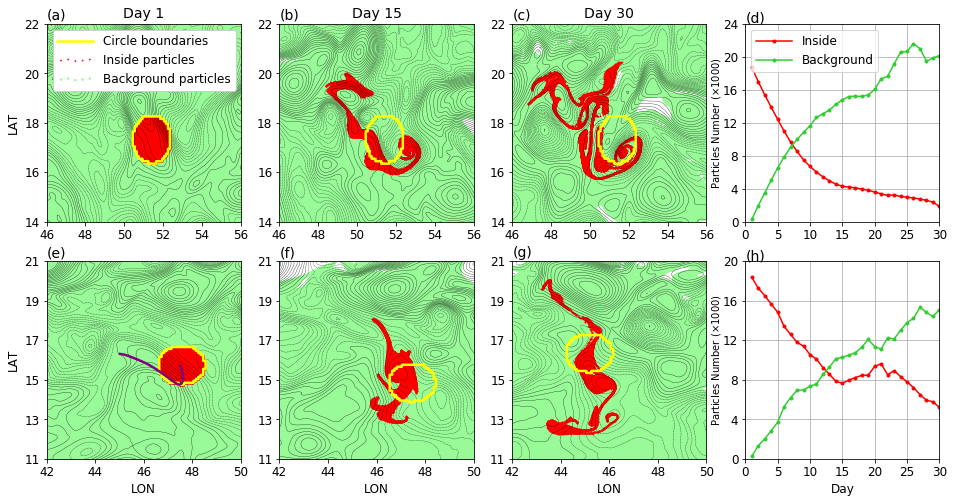

In [9]:
fig = plt.figure(figsize=(16, 8))

ax1 = plt.subplot(2, 4, 1)
hl1 = plt.plot(boun_x2[0], boun_y2[0], linewidth=2.5, color='yellow')
hl2 = plt.scatter(pxout2[0], pyout2[0], s=2, color='palegreen')
hl3 = plt.scatter(pxin2[0], pyin2[0], s=0.5, color='red')
plt.contour(sla.XC, sla.YC, sla[0, :, :],
            np.arange(-20, 20, 1), colors='k', linewidths=0.3)
plt.yticks(ticks=np.arange(14, 23, 2))
plt.xlim(46, 56)
plt.ylim(14, 22)
plt.text(46, 22.2, '(a)', size=14)
legend = plt.legend([hl1[0], hl3, hl2], ('Circle boundaries', 'Inside particles',
                                         'Background particles',), scatterpoints=5, loc='upper left', framealpha=1)
legend.get_frame().set_facecolor('w')
plt.ylabel('LAT')
plt.title('Day 1')

ax1 = plt.subplot(2, 4, 2)
hl1 = plt.plot(boun_x2[1], boun_y2[1], linewidth=2.5, color='yellow')
hl2 = plt.scatter(pxout2[1], pyout2[1], s=2, color='palegreen')
hl3 = plt.scatter(pxin2[1], pyin2[1], s=0.5, color='red')
plt.contour(sla.XC, sla.YC, sla[14, :, :],
            np.arange(-20, 20, 1), colors='k', linewidths=0.3)
plt.yticks(ticks=np.arange(14, 23, 2))
plt.xlim(46, 56)
plt.ylim(14, 22)
plt.text(46, 22.2, '(b)', size=14)
plt.title('Day 15')

ax1 = plt.subplot(2, 4, 3)
hl1 = plt.plot(boun_x2[2], boun_y2[2], linewidth=2.5, color='yellow')
hl2 = plt.scatter(pxout2[2], pyout2[2], s=2, color='palegreen')
hl3 = plt.scatter(pxin2[2], pyin2[2], s=0.5, color='red')
plt.contour(sla.XC, sla.YC, sla[29, :, :],
            np.arange(-20, 20, 1), colors='k', linewidths=0.3)
plt.yticks(ticks=np.arange(14, 23, 2))
plt.xlim(46, 56)
plt.ylim(14, 22)
plt.text(46, 22.2, '(c)', size=14)
plt.title('Day 30')

ax1 = plt.subplot(2, 4, 4)
hl1 = plt.plot(np.arange(1, 31, 1), num12/1000,
               color='r', linewidth=1.5, marker='.', label='Inside')
hl2 = plt.plot(np.arange(1, 31, 1), num22/1000,
               color='limegreen', linewidth=1.5, marker='.', label='Background')
plt.legend()
#plt.yticks(ticks=np.arange(0, 13, 2))
plt.grid()
plt.xlim(0, 30)
plt.ylim(0, 24)
plt.yticks(ticks=np.arange(0, 25, 4))
plt.xticks(ticks=np.arange(0, 31, 5))
plt.ylabel(r'Particles Number ($ \times$1000)', size=10, labelpad=0)
plt.text(0, 24.15, '(d)', size=14)

ax1 = plt.subplot(2, 4, 5)
hl1 = plt.plot(boun_x1[0], boun_y1[0], linewidth=2.5, color='yellow')
hl2 = plt.scatter(pxout1[0], pyout1[0], s=2, color='palegreen')
hl3 = plt.scatter(pxin1[0], pyin1[0], s=0.5, color='red')
plt.contour(sla.XC, sla.YC, sla[0, :, :],
            np.arange(-20, 20, 1), colors='k', linewidths=0.3)
plt.plot(cenx1, ceny1, color='purple', linewidth=2.5)
plt.yticks(ticks=np.arange(11, 22, 2))
plt.xlim(42, 50)
plt.ylim(11, 21)
plt.text(42, 21.2, '(e)', size=14)
plt.ylabel('LAT')
plt.xlabel('LON')


ax1 = plt.subplot(2, 4, 6)
hl1 = plt.plot(boun_x1[1], boun_y1[1], linewidth=2.5, color='yellow')
hl2 = plt.scatter(pxout1[1], pyout1[1], s=2, color='palegreen')
hl3 = plt.scatter(pxin1[1], pyin1[1], s=0.5, color='red')
plt.contour(sla.XC, sla.YC, sla[14, :, :],
            np.arange(-20, 20, 1), colors='k', linewidths=0.3)
plt.xlabel('LON')
plt.yticks(ticks=np.arange(11, 22, 2))
plt.xlim(42, 50)
plt.ylim(11, 21)
plt.text(42, 21.2, '(f)', size=14)


ax1 = plt.subplot(2, 4, 7)
hl1 = plt.plot(boun_x1[2], boun_y1[2], linewidth=2.5, color='yellow')
hl2 = plt.scatter(pxout1[2], pyout1[2], s=2, color='palegreen')
hl3 = plt.scatter(pxin1[2], pyin1[2], s=0.5, color='red')
plt.contour(sla.XC, sla.YC, sla[29, :, :],
            np.arange(-20, 20, 1), colors='k', linewidths=0.3)
plt.xlabel('LON')
plt.yticks(ticks=np.arange(11, 22, 2))
plt.xlim(42, 50)
plt.ylim(11, 21)
plt.text(42, 21.2, '(g)', size=14)

ax1 = plt.subplot(2, 4, 8)
hl1 = plt.plot(np.arange(1, 31, 1), num11/1000,
               color='r', linewidth=1.5, marker='.')
hl2 = plt.plot(np.arange(1, 31, 1), num21/1000,
               color='limegreen', linewidth=1.5, marker='.')
#plt.yticks(ticks=np.arange(0, 13, 2))
plt.grid()
plt.xlim(0, 30)
plt.ylim(0, 20)
plt.yticks(ticks=np.arange(0, 21, 4))
plt.xticks(ticks=np.arange(0, 31, 5))
plt.text(0, 20.14, '(h)', size=14)
plt.xlabel('Day')
plt.ylabel(r'Particles Number ($ \times$1000)', size=10, labelpad=0)

plt.savefig('Figure_14.png', dpi=300, bbox_inches='tight')